In this lesson, we'll transform the theoretical concepts of backpropagation and gradient descent into practical implementation using TensorFlow and Keras. Understanding these mechanisms is crucial for any deep learning practitioner because they form the foundation of how neural networks learn from data.

We'll apply these concepts to a real-world problem: predicting housing prices based on features like square footage, number of bedrooms, and neighborhood statistics using the California Housing dataset. This regression task provides an excellent context for understanding how neural networks learn continuous values through iterative weight adjustments.

Throughout this lesson, we'll follow a systematic process:

1. Prepare the data - Load, explore, and preprocess the California Housing dataset.
2. Design a neural network architecture - Create a model with appropriate layers for regression.
3. Configure the optimization process - Select loss functions and optimizers that implement gradient descent.
4. Train the model - Execute the backpropagation and gradient descent algorithms through Keras.
5. Visualize the learning process - Analyze how error decreases over time as the model learns.
6. Evaluate performance - Test how well our model generalizes to unseen data.

##### Step 1: Load and Explore the CA Housing Dataset

California Housing dataset shape: (20640, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target variable: Median house value in $100,000s

Descriptive Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude         PRIC

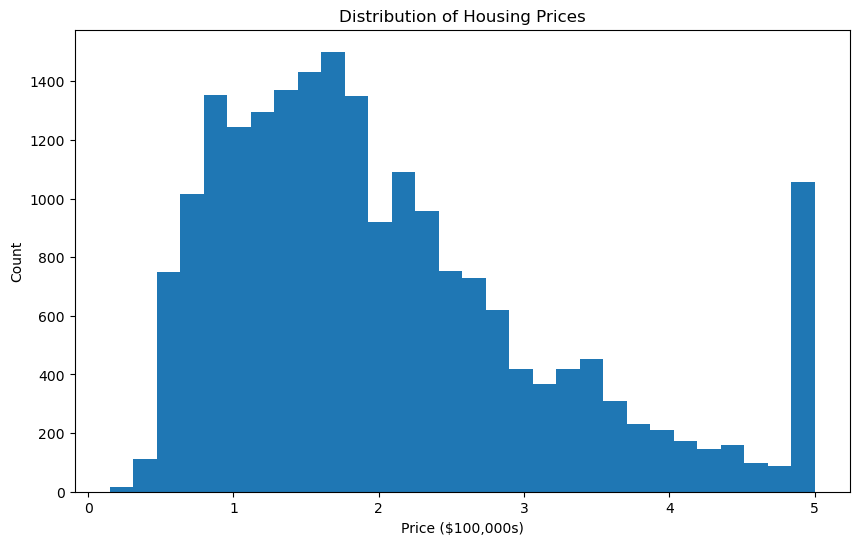


Feature correlations with price:
PRICE         1.000000
MedInc        0.688075
AveRooms      0.151948
HouseAge      0.105623
AveOccup     -0.023737
Population   -0.024650
Longitude    -0.045967
AveBedrms    -0.046701
Latitude     -0.144160
Name: PRICE, dtype: float64


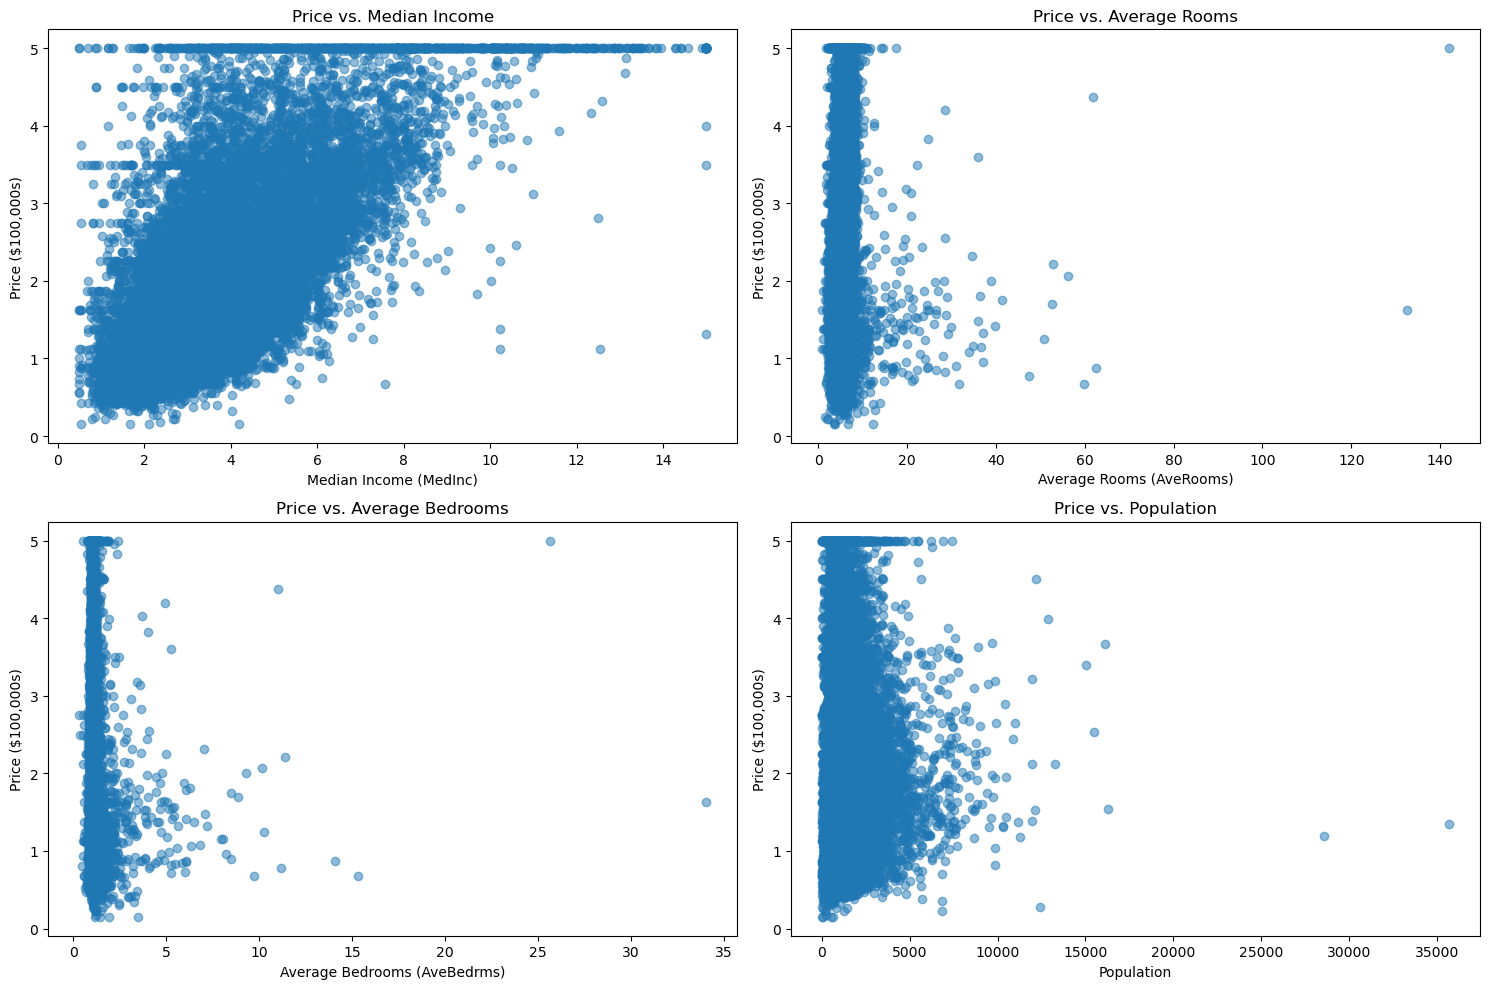

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Set seeda for reproducible results
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)

# Load the California Housing dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Load the dataset
housing = fetch_california_housing()
X = housing.data
y = housing.target

# Examine the dataset
print(f"California Housing dataset shape: {X.shape}")
print(f"Features: {housing.feature_names}")
print(f"Target variable: Median house value in $100,000s")

# View descriptive statistics
housing_df = pd.DataFrame(X, columns=housing.feature_names)
housing_df['PRICE'] = y
print("\nDescriptive Statistics:")
print(housing_df.describe())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Plot the distribution of housing prices
plt.figure(figsize=(10, 6))
plt.hist(y, bins=30)
plt.xlabel('Price ($100,000s)')
plt.ylabel('Count')
plt.title('Distribution of Housing Prices')
plt.show()

# Look at correlations with target variable
correlations = housing_df.corr()['PRICE'].sort_values(ascending=False)
print("\nFeature correlations with price:")
print(correlations)

# Plot a few key features against price
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(housing_df['MedInc'], housing_df['PRICE'], alpha=0.5)
plt.xlabel('Median Income (MedInc)')
plt.ylabel('Price ($100,000s)')
plt.title('Price vs. Median Income')

plt.subplot(2, 2, 2)
plt.scatter(housing_df['AveRooms'], housing_df['PRICE'], alpha=0.5)
plt.xlabel('Average Rooms (AveRooms)')
plt.ylabel('Price ($100,000s)')
plt.title('Price vs. Average Rooms')

plt.subplot(2, 2, 3)
plt.scatter(housing_df['AveBedrms'], housing_df['PRICE'], alpha=0.5)
plt.xlabel('Average Bedrooms (AveBedrms)')
plt.ylabel('Price ($100,000s)')
plt.title('Price vs. Average Bedrooms')

plt.subplot(2, 2, 4)
plt.scatter(housing_df['Population'], housing_df['PRICE'], alpha=0.5)
plt.xlabel('Population')
plt.ylabel('Price ($100,000s)')
plt.title('Price vs. Population')

plt.tight_layout()
plt.show()